End-to-End Two Person Speaker Recognition
=====================

In [1]:
import os
import sys
import librosa
import tflearn
import seaborn as sns
import pydub
import wave
import pickle
import pylab
import tensorflow as tf
import librosa.display
import IPython.display
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as ms
sys.path.append('data_prep/')
import speech_data
import segment_data

# plot configurations
sns.set_palette(sns.xkcd_palette(['teal']))
sns.set_style("whitegrid")
sns.set_context(font_scale=1, rc={"lines.linewidth": 2.5})
%matplotlib inline

hdf5 not supported (please install/reinstall h5py)


In [25]:
# load constants - training directory, testing directory
full_training_data = '/home/cc/Data/OCI-Train/'
full_testing_data = '/home/cc/Data/OCI-Test'
training = '/home/cc/Data/train/'
testing = '/home/cc/Data/test/'
full_sample = '/home/cc/Voice-Identification/audio_samples/full/'
seg_sample = '/home/cc/Voice-Identification/audio_samples/segment/'

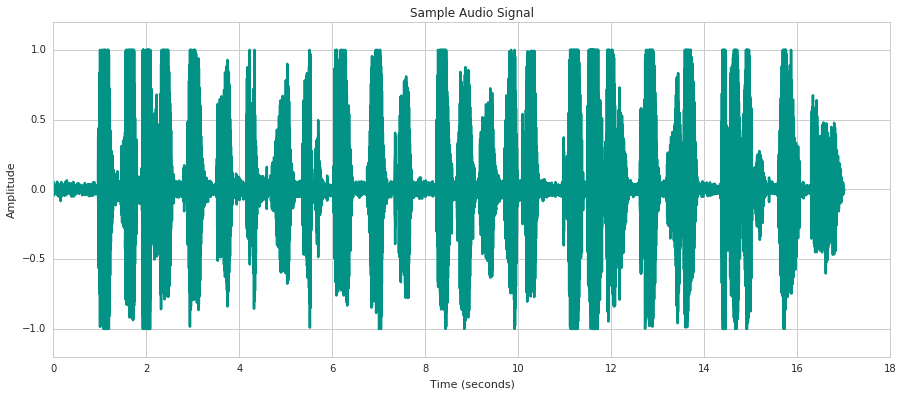

In [26]:
# load the sample file, play it back. Also show the graph of sample
y, fs = librosa.load(full_sample + 'speaker_sample.wav')
t = np.linspace(0, len(y)/fs, num=len(y))
plt.figure(figsize= (15, 6))
sns.plt.plot(t,y)
sns.plt.ylim(-1.2, 1.2)
sns.plt.xlabel('Time (seconds)')
sns.plt.ylabel('Amplitude')
sns.plt.title('Sample Audio Signal')
plt.show()
IPython.display.Audio(data=y, rate=fs)

In [27]:
# testing in case I want to create new data with noise for training
noise = np.random.normal(0,0.05,374850)
z = y + noise

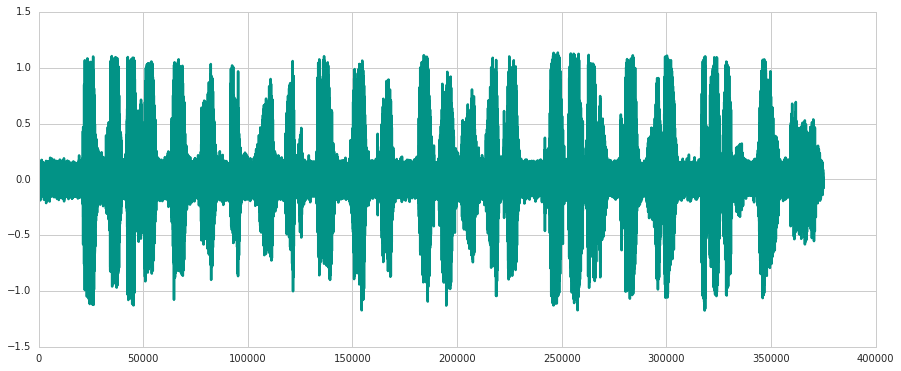

In [28]:
plt.figure(figsize= (15, 6))
sns.plt.plot(z)
plt.show()

In [29]:
IPython.display.Audio(data=z, rate=fs)

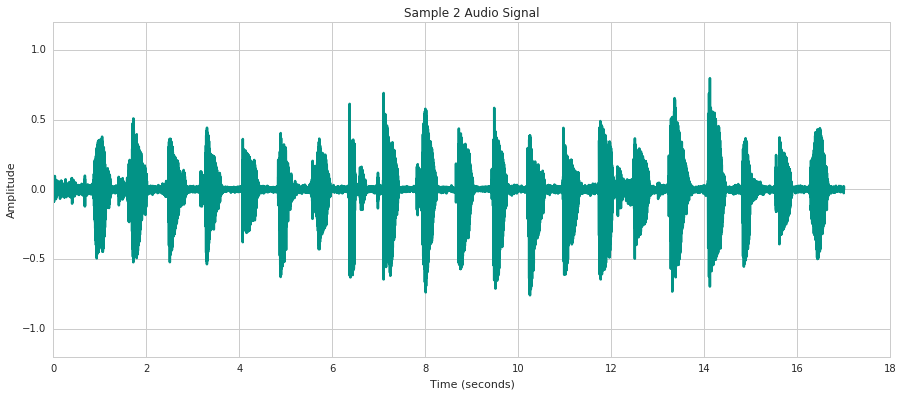

In [31]:
# load the sample file, play it back. Also show the graph of sample
y1, fs1 = librosa.load(full_sample + 'speaker2_sample.wav')
t1 = np.linspace(0, len(y1)/fs1, num=len(y1))
plt.figure(figsize= (15, 6))
sns.plt.plot(t1,y1)
sns.plt.ylim(-1.2, 1.2)
sns.plt.xlabel('Time (seconds)')
sns.plt.ylabel('Amplitude')
sns.plt.title('Sample 2 Audio Signal')
plt.show()
IPython.display.Audio(data=y1, rate=fs1)

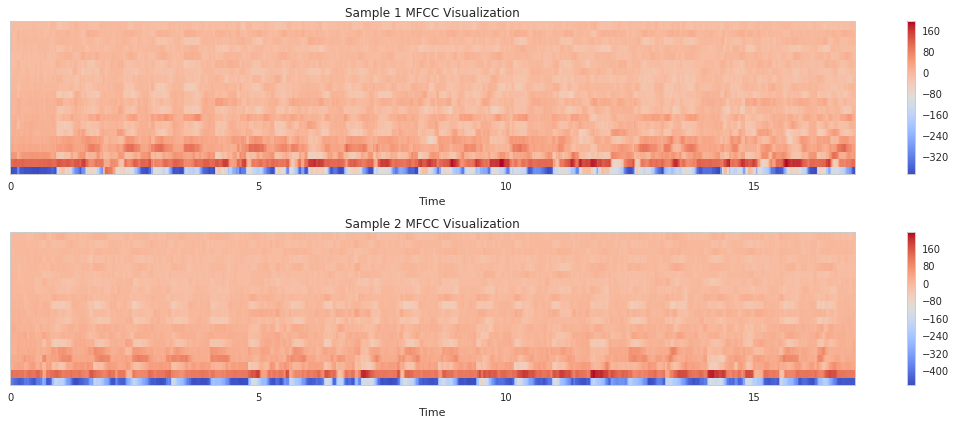

In [8]:
# perform mfcc calculation, display the result in graphic form
mfcc = librosa.feature.mfcc(y=y, sr=fs)
mfcc1 = librosa.feature.mfcc(y=y1, sr=fs1)
plt.figure(figsize= (15, 6))
plt.subplot(2,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('Sample 1 MFCC Visualization')
plt.subplot(2,1,2)
librosa.display.specshow(mfcc1, x_axis='time')
plt.colorbar()
plt.title('Sample 2 MFCC Visualization')
plt.tight_layout()
plt.show()

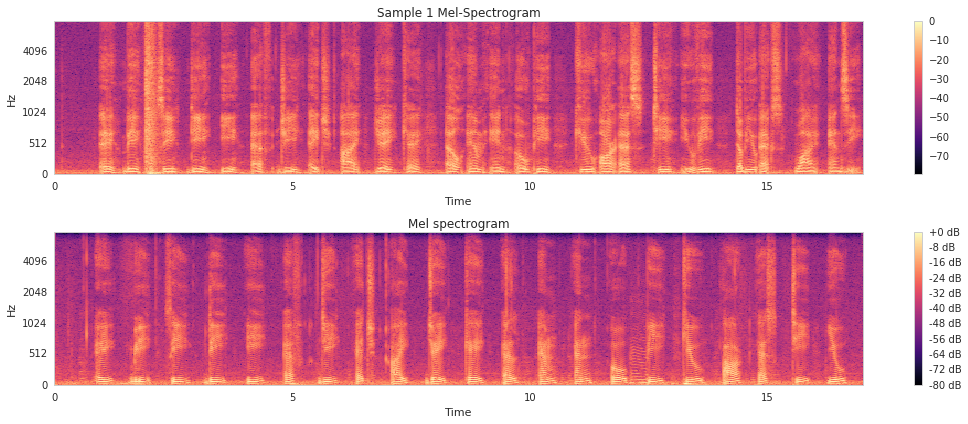

In [9]:
# additionally, display the mel-spectrogram of the audio files
D = librosa.stft(y)
S, phase = librosa.magphase(D)
D1 = librosa.stft(y1)
S1, phase1 = librosa.magphase(D1)
plt.figure(figsize= (15, 6))
plt.subplot(2,1,1)
librosa.display.specshow(librosa.logamplitude(S, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar()
plt.title('Sample 1 Mel-Spectrogram')
plt.subplot(2,1,2)
librosa.display.specshow(librosa.logamplitude(S1, ref_power=np.max), y_axis='mel', fmax=8000, x_axis='time')
plt.title('Sample 2 Mel-Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')
plt.tight_layout()
plt.show()

In [10]:
# now need to segment training and testing data into the correct directories / also for samples
length = 1
if not os.listdir(training):
    segment_data.segment(data=full_training_data, seg_location=training, length=length)
if not os.listdir(testing):
    segment_data.segment(data=full_testing_data, seg_location=testing, length=length)
if not os.listdir(seg_sample):
    segment_data.segment(data=full_sample, seg_location=seg_sample, length=length)

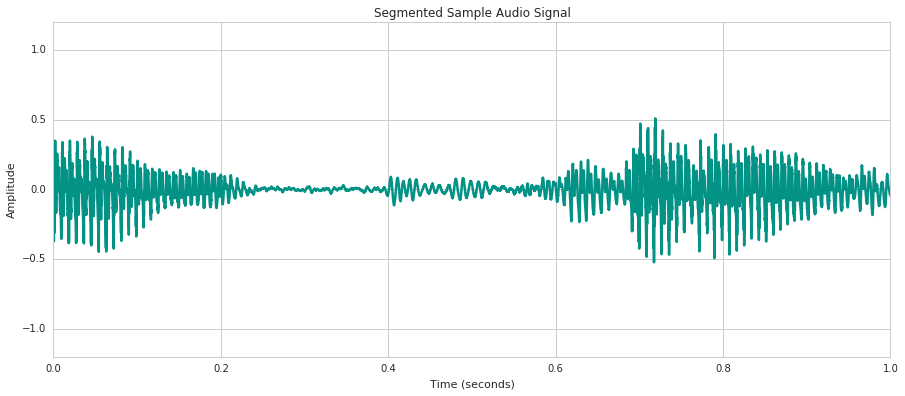

In [11]:
# use the segmented data to visualize in a different way
y_seg, fs_seg = librosa.load(seg_sample + 'speaker2_1.wav')
t_seg = np.linspace(0, len(y_seg)/fs_seg, num=len(y_seg))
plt.figure(figsize= (15, 6))
sns.plt.plot(t_seg,y_seg)
sns.plt.ylim(-1.2, 1.2)
sns.plt.xlabel('Time (seconds)')
sns.plt.ylabel('Amplitude')
sns.plt.title('Segmented Sample Audio Signal')
plt.show()
IPython.display.Audio(data=y_seg, rate=fs_seg)

In [12]:
# using librosa, extract mfcc coefficients step-by-step --> compare to earlier
# this should be done by changing overlap with 'hop_length' parameter
hop_length = 128 # default = 512
frame_length = 2048 # default = 2048
stft = librosa.stft(y=y, hop_length=hop_length, n_fft=2048)

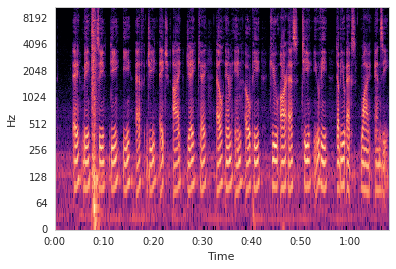

In [13]:
librosa.display.specshow(librosa.amplitude_to_db(stft, ref=np.max), y_axis='log', x_axis='time')
plt.show()

In [14]:
mfcc_try = librosa.feature.mfcc(y=y, sr=fs, hop_length=hop_length, n_mfcc=20)

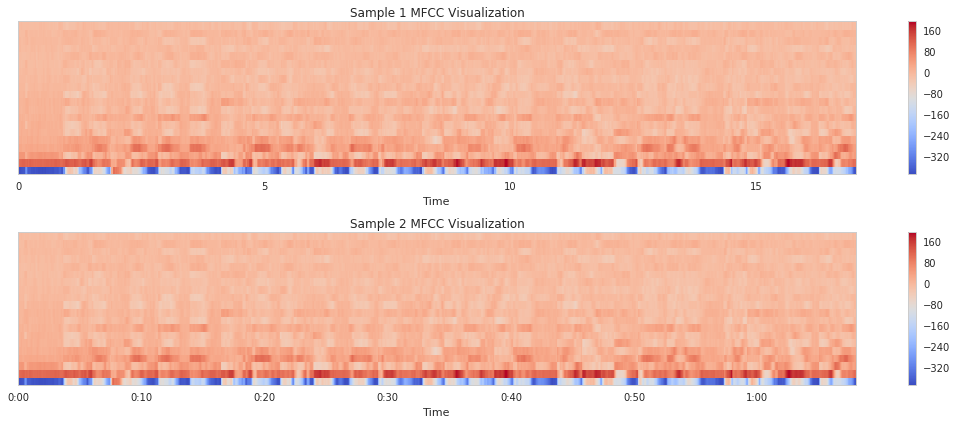

In [15]:
plt.figure(figsize= (15, 6))
plt.subplot(2,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('Sample 1 MFCC Visualization')
plt.subplot(2,1,2)
librosa.display.specshow(mfcc_try, x_axis='time')
plt.colorbar()
plt.title('Sample 2 MFCC Visualization')
plt.tight_layout()
plt.show()

In [16]:
# calculate the mfcc matrices for training from the segmented data
#X = []
#Y = []
#speakers = speech_data.get_speakers(training)
#for f in os.listdir(training):
#    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
#    y, sr = librosa.load(training + f)
#    X.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length))

In [17]:
# calculate the mfcc, delta, delta-delta matrices for training from the segmented data
X = []
Y = []
speakers = speech_data.get_speakers(training)
for f in os.listdir(training):
    Y.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
    y, sr = librosa.load(training + f)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X.append(np.c_[mfcc,delta,delta2])

number of files: 203
(2, ' speakers: ', ['arun', 'andrew'])


In [18]:
# define the network and the model for training
layer_size = 128
dropout = 0.7
learning_rate = 0.001
tflearn.init_graph(num_cores=8,gpu_memory_fraction=0.5)

net = tflearn.input_data(shape=[None, 20, 519])
net = tflearn.fully_connected(net, layer_size, activation='relu')
net = tflearn.fully_connected(net, layer_size, activation='relu')
net = tflearn.fully_connected(net, layer_size, activation='relu')
#net = tflearn.fully_connected(net, layer_size, activation='relu')
#net = tflearn.fully_connected(net, layer_size, activation='relu')
#net = tflearn.fully_connected(net, layer_size, activation='relu')
net = tflearn.dropout(net, dropout)
net = tflearn.fully_connected(net, len(speakers), activation='softmax')
net = tflearn.regression(net, optimizer='adam', loss='categorical_crossentropy', learning_rate=learning_rate)

In [19]:
# now train the model!
run_id='OCI_hopLength_128_6'
model = tflearn.DNN(net)
model.fit(X, Y, n_epoch=100, show_metric=True, snapshot_step=1000, run_id=run_id, validation_set=0.1)

Training Step: 300  | total loss: 0.13233
| Adam | epoch: 100 | loss: 0.13233 - acc: 0.9774 | val_loss: 0.30529 - val_acc: 0.9048 -- iter: 182/182
Training Step: 300  | total loss: 0.13233
| Adam | epoch: 100 | loss: 0.13233 - acc: 0.9774 | val_loss: 0.30529 - val_acc: 0.9048 -- iter: 182/182
--


In [20]:
# calculate the mfcc matrices for testing from the segmented data
Xtest = []
Ytest = []
speakers = speech_data.get_speakers(testing)
for f in os.listdir(testing):
    Ytest.append(speech_data.one_hot_from_item(speech_data.speaker(f), speakers))
    y, sr = librosa.load(testing + f)
    #Xtest.append(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20))
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20, hop_length=hop_length)
    delta = librosa.feature.delta(mfcc)
    delta2 = librosa.feature.delta(mfcc, order=2)
    Xtest.append(np.c_[mfcc,delta,delta2])

number of files: 71
(2, ' speakers: ', ['arun', 'andrew'])


In [21]:
# now test model over the test segments
result = model.predict(Xtest)
c = 0
for f,r in zip(os.listdir(testing), result):
    res = speech_data.one_hot_to_item(r, speakers)
    if res in f:
        c = c + 1
acc = float(c) / float(len(Xtest))
print('Test set accuracy: %s' %str(acc))

Test set accuracy: 0.957746478873


In [22]:
# append results to text file
# need to include: layer size, dropout size, train / test results
l = ['ID : ' + run_id + 'Length: ' + str(length), 'Layer Size : ' + str(layer_size), 'Dropout: ' + str(dropout), 'Learning Rate: ' + str(learning_rate), 'Test: ' + str(acc)]
os.chdir('/home/cc/Voice-Identification/')
with open('layer_stats.txt', 'a') as myfile:
    [myfile.write(a + ' , ') for a in l]
    myfile.write('\n')

In [23]:
# now test the model over the two sample files shown above
sample_result = []
all_y = []
all_fs = []
for item in os.listdir(seg_sample):
    y_seg, fs_seg = librosa.load(seg_sample + item)
    all_y.append(y_seg)
    all_fs.append(fs_seg)
    mfcc_seg = librosa.feature.mfcc(y_seg, fs_seg, n_mfcc=20, hop_length=hop_length)
    mfcc_seg = np.reshape(mfcc_seg, newshape=(1,20,261))
    result = model.predict(mfcc_seg)
    sample_result.append(item + ' : ' + str(speech_data.one_hot_to_item(result, speakers)))

ValueError: cannot reshape array of size 3460 into shape (1,20,261)

In [ ]:
# display results - talk about why arun is here so much
for y, fs, r in zip(all_y, all_fs, sample_result):
    print(r)
    IPython.display.display(IPython.display.Audio(y, rate=fs))